# Energy resolution after  delta-z effect correction


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri Nov 13 10:30:18 2020


### load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

In [6]:
runs      = [8182, 8183, 8184]
filenames = [get_filename(run) for run in runs]
dft       = bes.get_dft(filenames)

data filename:  /data_extra2/jrenner/analysis/NEW/8182/hdf5/cdst/trigger2/cdst_combined_8182.h5
data filename:  /data_extra2/jrenner/analysis/NEW/8183/hdf5/cdst/trigger2/cdst_combined_8183.h5
data filename:  /data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_combined_8184.h5


### selections and ranges

In [7]:
ranges     = bes.get_ranges()
print([(key, ranges[key]) for key in ranges.keys()])

selections = bes.get_selections(dft, ranges)
print(selections.keys())

selections['fidutial'] = selections.logical_and('numb_of_tracks.one', 'energy', 'z_min', 'z_max', 'r_max')

[('numb_of_tracks.one', (0.5, 1.5)), ('nS2', (0.5, 1.5)), ('energy', (0.0, 3.0)), ('energy.cs', (0.65, 0.71)), ('energy.ds', (1.55, 1.75)), ('energy.ph', (2.5, 3.0)), ('enecor.cs', (0.65, 0.71)), ('enecor.ds', (1.55, 1.75)), ('enecor.ph', (2.5, 3.0)), ('z_min', (50.0, 500.0)), ('z_max', (50.0, 500.0)), ('r_max', (0.0, 180.0)), ('dz_track.cs', (8.0, 32.0)), ('dz_track.ds', (24.0, 72.0)), ('dz_track.ph', (35.0, 130.0))]
dict_keys(['numb_of_tracks.one', 'energy', 'energy.cs', 'energy.ds', 'energy.ph', 'enecor.cs', 'enecor.ds', 'enecor.ph', 'z_min', 'z_max', 'r_max', 'dz_track.cs', 'dz_track.ds', 'dz_track.ph'])


### Energy 

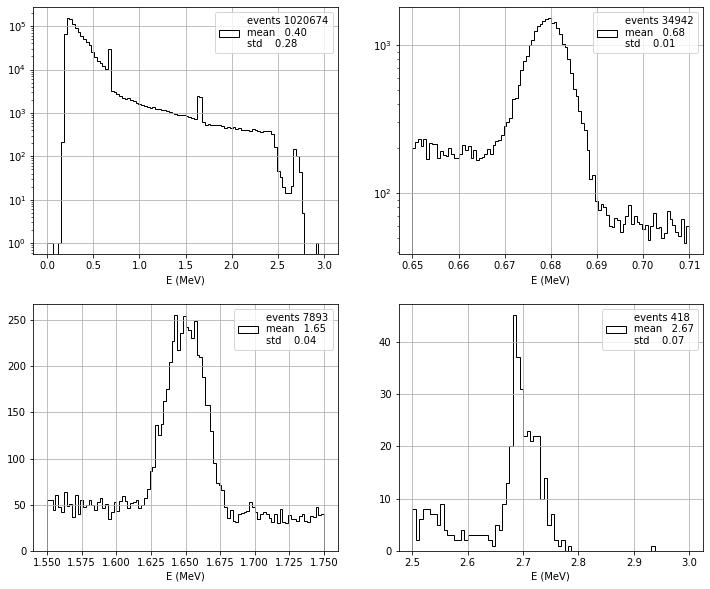

In [8]:
def plt_energies(enes, sel = None):

    xsel = sel if sel is not None else enes > np.min(enes)

    subplot = pltext.canvas(4, 2)
    subplot(1)
    pltext.hist(enes[xsel], 100, range = ranges['energy'], ylog = True, xylabels = 'E (MeV)'); 
    subplot(2)
    pltext.hist(enes[xsel], 100, range = ranges['energy.cs'], ylog = True, xylabels = 'E (MeV)');
    subplot(3)
    pltext.hist(enes[xsel], 100, range = ranges['energy.ds'], xylabels = 'E (MeV)');
    subplot(4)
    pltext.hist(enes[xsel], 80, range  = ranges['energy.ph'], xylabels = 'E (MeV)');


plt_energies(dft.energy, selections['fidutial'])

In [9]:
def plt_energies_fit(enes, ranges, parameters, selections = None):

    nsize = len(ranges)
    subplot = pltext.canvas(nsize)
    
    selections = selections if selections is not None else nsize * [enes > np.min(enes)]
    
    epars = []
    for i in range(nsize):
        subplot(i + 1)
        xsel, xpars   = selections[i] & ut.in_range(enes, ranges[i]), parameters[i]
        pars, parscov = pltext.hfit(enes[xsel], 'gausline', xpars, formate = '7.4f');
        epars.append((pars, parscov))
 
    dpars = {}
    dpars['energy'] = [ipars[1] for ipars, iparscov in epars]
    dpars['sigma']  = [ipars[2] for ipars, iparscov in epars]
    dpars['usigma'] = [iparscov[2] for ipars, iparscov in epars]
    dpars['R']      = [235. * ipars[2]/ipars[1] for ipars, iparscov in epars]
    dpars['uR']     = [235. * iparscov[2]/ipars[1] for ipars, iparscov in epars]


    dferes = pd.DataFrame(dpars)
    
    return dferes

fidutial cuts
energy 
      energy     sigma    usigma         R        uR
0  0.679453  0.004100  0.000027  1.418116  0.009253
1  1.649889  0.013807  0.000250  1.966575  0.035676
2  2.697565  0.023176  0.001219  2.018954  0.106154
fidutial cuts


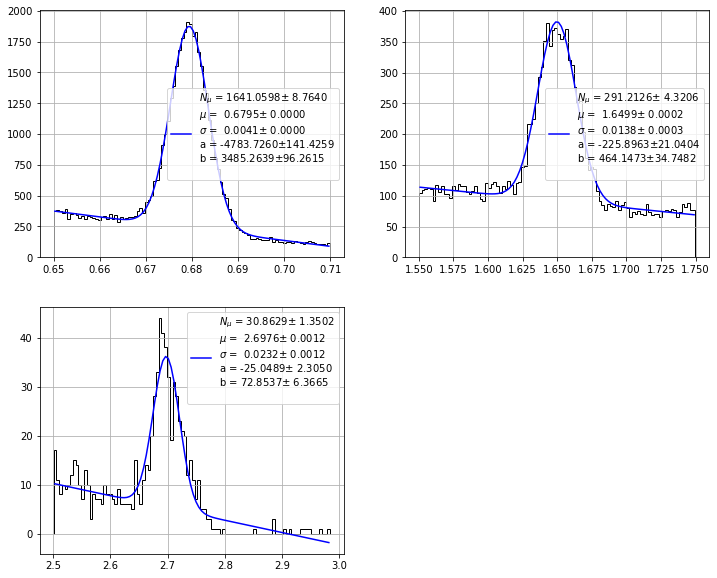

In [10]:
xsel    = selections['numb_of_tracks.one']
xranges = (ranges['energy.cs'], ranges['energy.ds'], ranges['energy.ph'])
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
dfenes0 = plt_energies_fit(dft.energy, xranges, xpars0, 3*[xsel])
print('fidutial cuts')
print('energy \n', dfenes0)
print('fidutial cuts')

fidutial cuts
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.682936  0.003575  0.000025  1.230116  0.008649
1  1.669784  0.007703  0.000099  1.084126  0.013933
2  2.768835  0.012447  0.000406  1.056423  0.034476


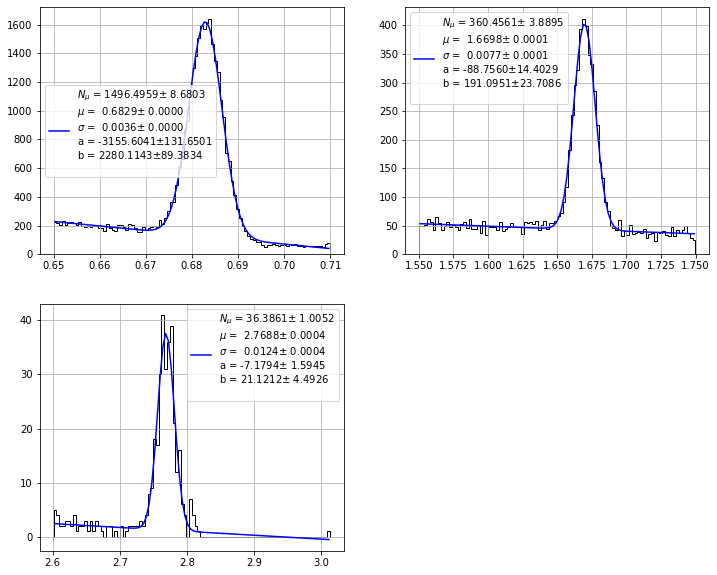

In [11]:
xsel    = selections['fidutial']
xranges = [ranges['enecor.cs'], ranges['enecor.ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.enecor, xranges, xpars0, 3*[xsel,])
print('fidutial cuts')
print('correced by dz-effect energy \n', dfenes1)

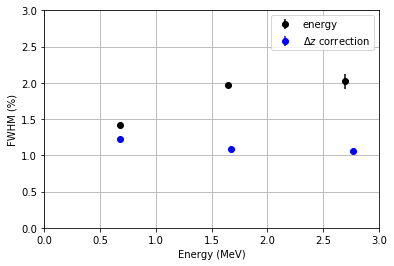

In [12]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');

### extra selection in $\Delta z$ range

fidutial cuts with delta-z range
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.682900  0.003547  0.000026  1.220630  0.008843
1  1.669004  0.007333  0.000087  1.032546  0.012232
2  2.767855  0.011678  0.000352  0.991469  0.029844


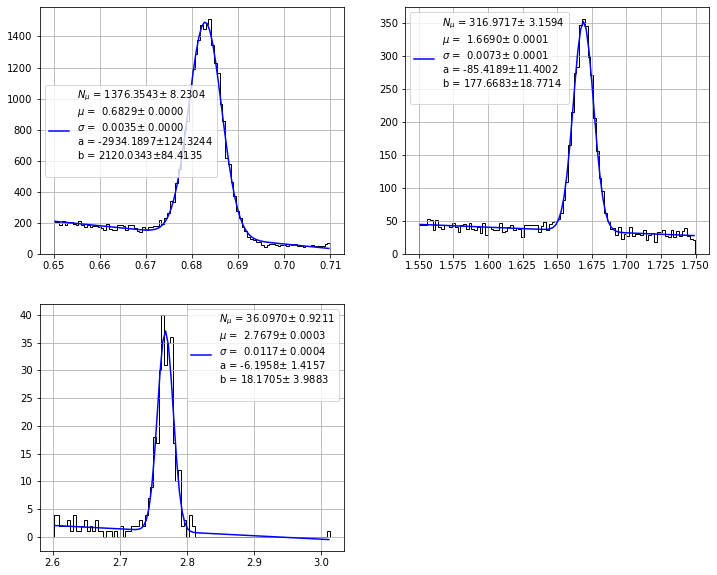

In [13]:
xsels = (selections.logical_and('fidutial', 'dz_track.cs'), 
         selections.logical_and('fidutial', 'dz_track.ds'), 
         selections.logical_and('fidutial', 'dz_track.ph'))
xranges = [ranges['enecor.cs'], ranges['enecor.ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (10.,  1.65, 0.013,  1., 50), (10.,  2.75, 0.01,  1., 10.))
dfenes1 = plt_energies_fit(dft.enecor, xranges, xpars0, xsels)
print('fidutial cuts with delta-z range')
print('correced by dz-effect energy \n', dfenes1)

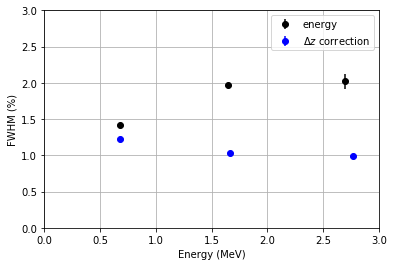

In [14]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');